In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from cloropleth import choropleth

%matplotlib inline
%config InlineBackend.figure_format='retina'

DATA_PATH = Path('../data')

SCL_DATA_PATH = DATA_PATH / 'raw' / 'scl'
PATH_CENSUS = SCL_DATA_PATH / "census"

INTERIM_CL = DATA_PATH / 'interim' / 'scl'

EXTERNAL_CL = DATA_PATH / 'external' / 'scl'
PATH_URBAN_AREAS = EXTERNAL_CL / "urban_areas"
PATH_R13 = EXTERNAL_CL / "R13"

In [15]:
census = (pd.read_csv(PATH_CENSUS / 'Censo2017_Manzanas.csv', sep=';')
          .merge(pd.read_csv(PATH_CENSUS / 'Censo2017_Identificación_Geográfica' / 'Microdato_Censo2017-Urbano.csv', sep=';'))
          .pipe(lambda x: x[x.REGION == 13])
          .drop('ZONA', axis=1)
          .drop_duplicates()
         )
count_columns = ['HOMBRES', 'MUJERES','EDAD_0A5', 'EDAD_6A14', 'EDAD_15A64', 'EDAD_65YMAS', 'INMIGRANTES']
for col in count_columns:
    census[col] = census[col].replace('*', 0).astype(int)
dc_values = census.groupby(['REGION', 'PROVINCIA', 'COMUNA', 'DC'])[count_columns].sum().reset_index().rename(columns={'DC': 'COD_DISTRI'})

dc_values

REGION  PROVINCIA  COMUNA  COD_DISTRI  HOMBRES  MUJERES  EDAD_0A5  \
0        13        131   13101           1     5151     5076       320   
1        13        131   13101           2    10755    10144      1111   
2        13        131   13101           3    12092    11490      1230   
3        13        131   13101           4     6539     7026       667   
4        13        131   13101           5     4872     5042       675   
..      ...        ...     ...         ...      ...      ...       ...   
406      13        136   13604           3     9742     9924      1540   
407      13        136   13604           4    14139    14479      2272   
408      13        136   13605           1    11671    12429      1736   
409      13        136   13605           2    15387    16198      2731   
410      13        136   13605           3    13258    14016      2036   

     EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  
0          264        8482          932         1919  
1          959       17455         1232         7824  
2         1043       19663         1069         7824  
3          858       10493         1473         2583  
4          821        7503          858         3450  
..         ...         ...          ...          ...  
406       2193       13318         2205          508  
407       3598       19935         2003          593  
408       3164       16419         2203          299  
409       3976       21746         2300          520  
410       3218       18247         3280          254  

[411 rows x 11 columns]

/home/flac/miniconda3/envs/aves/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

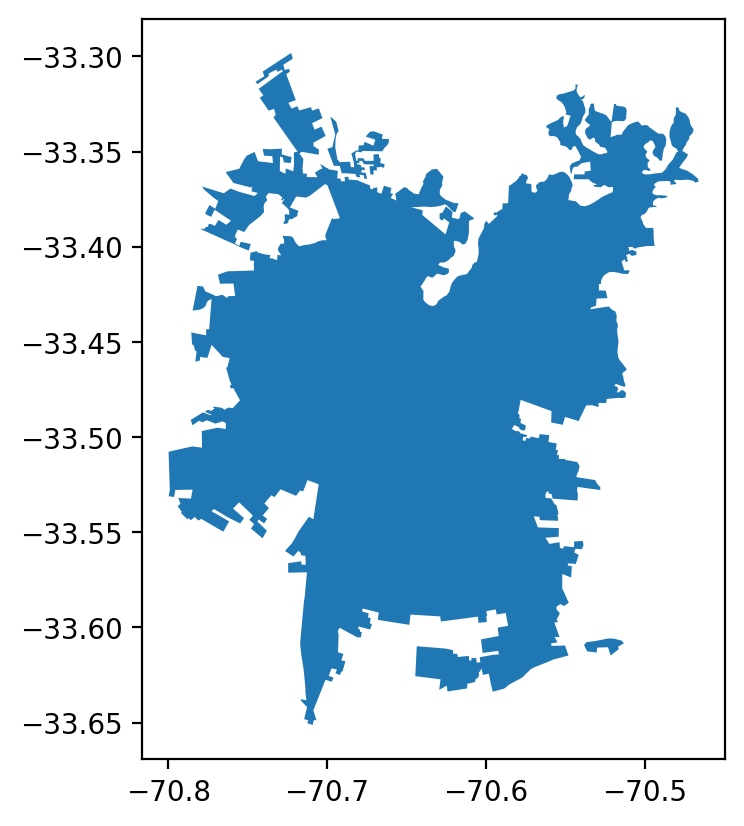

In [16]:
urban_stgo = (gpd.read_file(PATH_URBAN_AREAS, crs={'init': 'epsg:5361'})
               .to_crs({'init': 'epsg:4326'})
               .pipe(lambda x: x[x.NOMBRE == 'Santiago'].copy()))
    
urban_stgo.plot()

451


<Axes: >

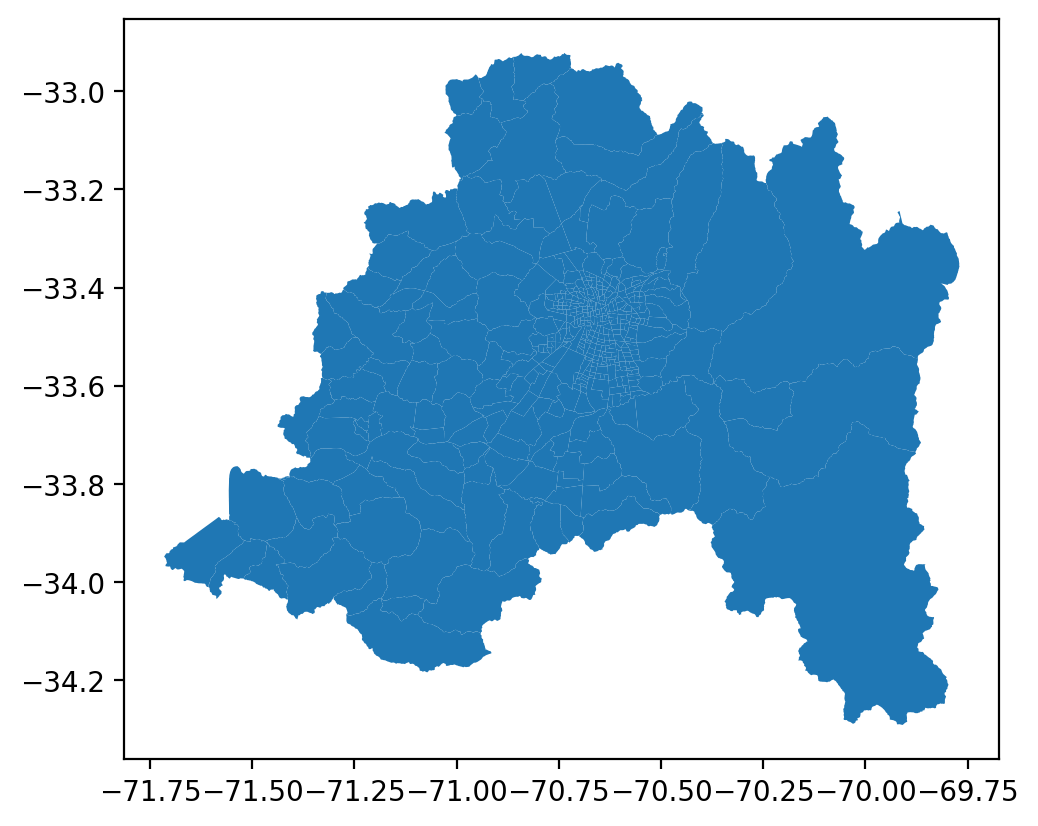

In [17]:
orig = (gpd.read_file(PATH_R13).assign(REGION=lambda x: x.REGION.astype(int))
         .assign(PROVINCIA=lambda x: x.PROVINCIA.astype(int))
         .assign(COMUNA=lambda x: x.COMUNA.astype(int))
         .assign(COD_DISTRI=lambda x: x.COD_DISTRI.astype(int)))
print(len(orig))


orig.plot()

In [18]:
urban_districts = (orig
         .pipe(lambda x: x.assign(geometry=x.geometry.map(lambda y: urban_stgo.loc[385].geometry.intersection(y))))
         .pipe(lambda x: x[(x.area > 0)].copy()))
len(urban_districts)

/tmp/ipykernel_5473/2341987484.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  .pipe(lambda x: x[(x.area > 0)].copy()))


342

<Axes: >

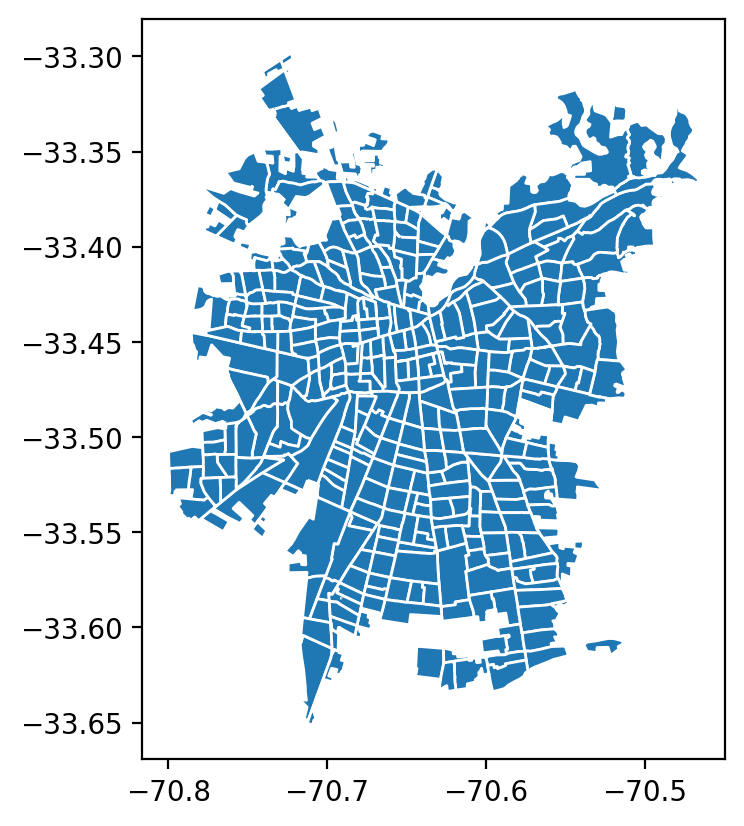

In [19]:
urban_districts.plot(edgecolor='white')

In [23]:
urban_districts.to_file(INTERIM_CL / 'urban_districts' / 'stgo_urban_districts.shp', driver='ESRI Shapefile')

/home/flac/miniconda3/envs/aves/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<Axes: >

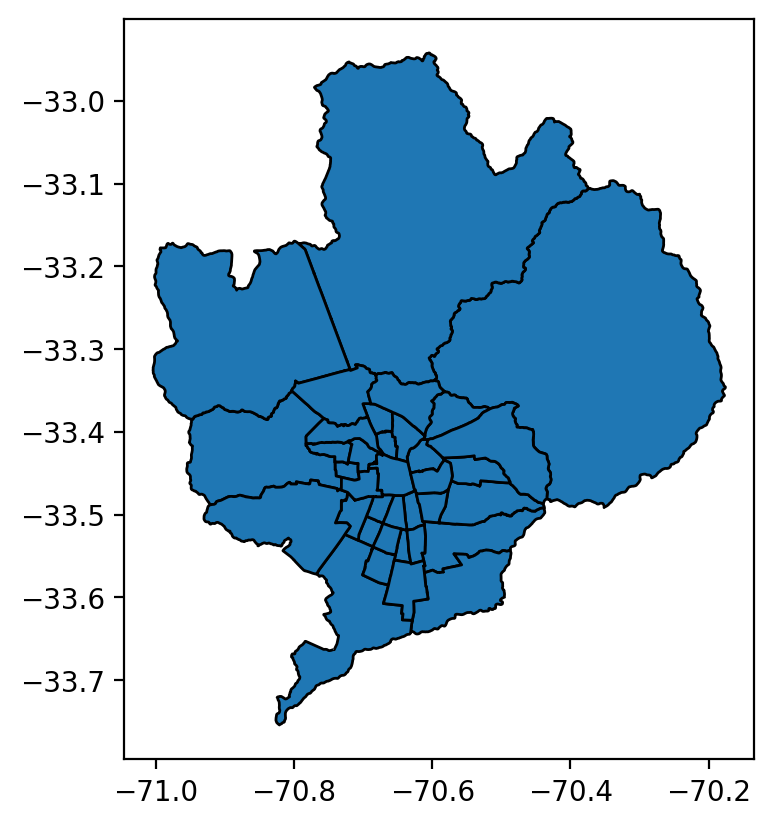

In [25]:
municipalities = gpd.read_file(EXTERNAL_CL / "shapefile_comunas")
municipalities = municipalities.to_crs(urban_stgo.crs)


urban_municipalities = gpd.sjoin(municipalities, urban_stgo, how='inner', op='intersects')
urban_municipalities.plot(edgecolor="black")

In [26]:
urban_data = urban_districts.merge(dc_values, how='inner')
urban_data.sample(5)

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
27       13        131   13132           1  REGIÓN METROPOLITANA DE SANTIAGO   
169      13        131   13127           6  REGIÓN METROPOLITANA DE SANTIAGO   
242      13        131   13126           8  REGIÓN METROPOLITANA DE SANTIAGO   
102      13        131   13131           4  REGIÓN METROPOLITANA DE SANTIAGO   
9        13        131   13114           6  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI     DESC_COMUN            DESC_DISTR  \
27    SANTIAGO       VITACURA       NACIONES UNIDAS   
169   SANTIAGO       RECOLETA  CEMENTERIO ISRAELITA   
242   SANTIAGO  QUINTA NORMAL             CATAMARCA   
102   SANTIAGO      SAN RAMÓN        GENERAL KÖRNER   
9     SANTIAGO     LAS CONDES         LOS DOMÍNICOS   

                                              geometry  HOMBRES  MUJERES  \
27   POLYGON ((-70.60002 -33.40810, -70.60002 -33.4...     6723     8410   
169  POLYGON ((-70.62915 -33.40008, -70.62917 -33.4...    11776    12316   
242  POLYGON ((-70.71537 -33.41538, -70.71496 -33.4...     7913     8112   
102  POLYGON ((-70.63288 -33.55412, -70.63280 -33.5...     7066     7139   
9    POLYGON ((-70.54507 -33.40829, -70.54504 -33.4...     3125     3668   

     EDAD_0A5  EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  
27       1269        999        9580         2968         2030  
169      1728       2667       16154         3189         1537  
242      1179       1703       10950         2067         1436  
102      1084       1631        9390         1762          168  
9         223        398        4562         1253          399

In [28]:
urban_data['POPULATION'] = urban_data['HOMBRES'] + urban_data['MUJERES']
urban_data.POPULATION.describe()

count      342.000000
mean     17858.394737
std      12753.122789
min        440.000000
25%      11400.750000
50%      14643.500000
75%      20322.500000
max      98090.000000
Name: POPULATION, dtype: float64

In [29]:
urban_data['RATIO'] = ((urban_data['MUJERES'] - urban_data['HOMBRES']) / urban_data['POPULATION'] * 100)
urban_data.RATIO.describe()

count    342.000000
mean       2.742708
std        5.605334
min      -83.073011
25%        1.301957
50%        2.728653
75%        4.469270
max       11.570881
Name: RATIO, dtype: float64

In [30]:
urban_data['IMMIGRANT_%'] = urban_data['INMIGRANTES'] / urban_data['POPULATION'] * 100
urban_data['IMMIGRANT_%'].describe()

count    342.000000
mean       8.224377
std        9.434377
min        0.000000
25%        2.399305
50%        4.916366
75%        8.813560
max       53.320236
Name: IMMIGRANT_%, dtype: float64

In [31]:
urban_data['RETIRED_%'] = urban_data['EDAD_65YMAS'] / urban_data['POPULATION'] * 100
urban_data['RETIRED_%'].describe()

count    342.000000
mean      11.914783
std        4.043622
min        0.000000
25%        8.924081
50%       12.508958
75%       14.787759
max       20.260310
Name: RETIRED_%, dtype: float64

<Axes: >

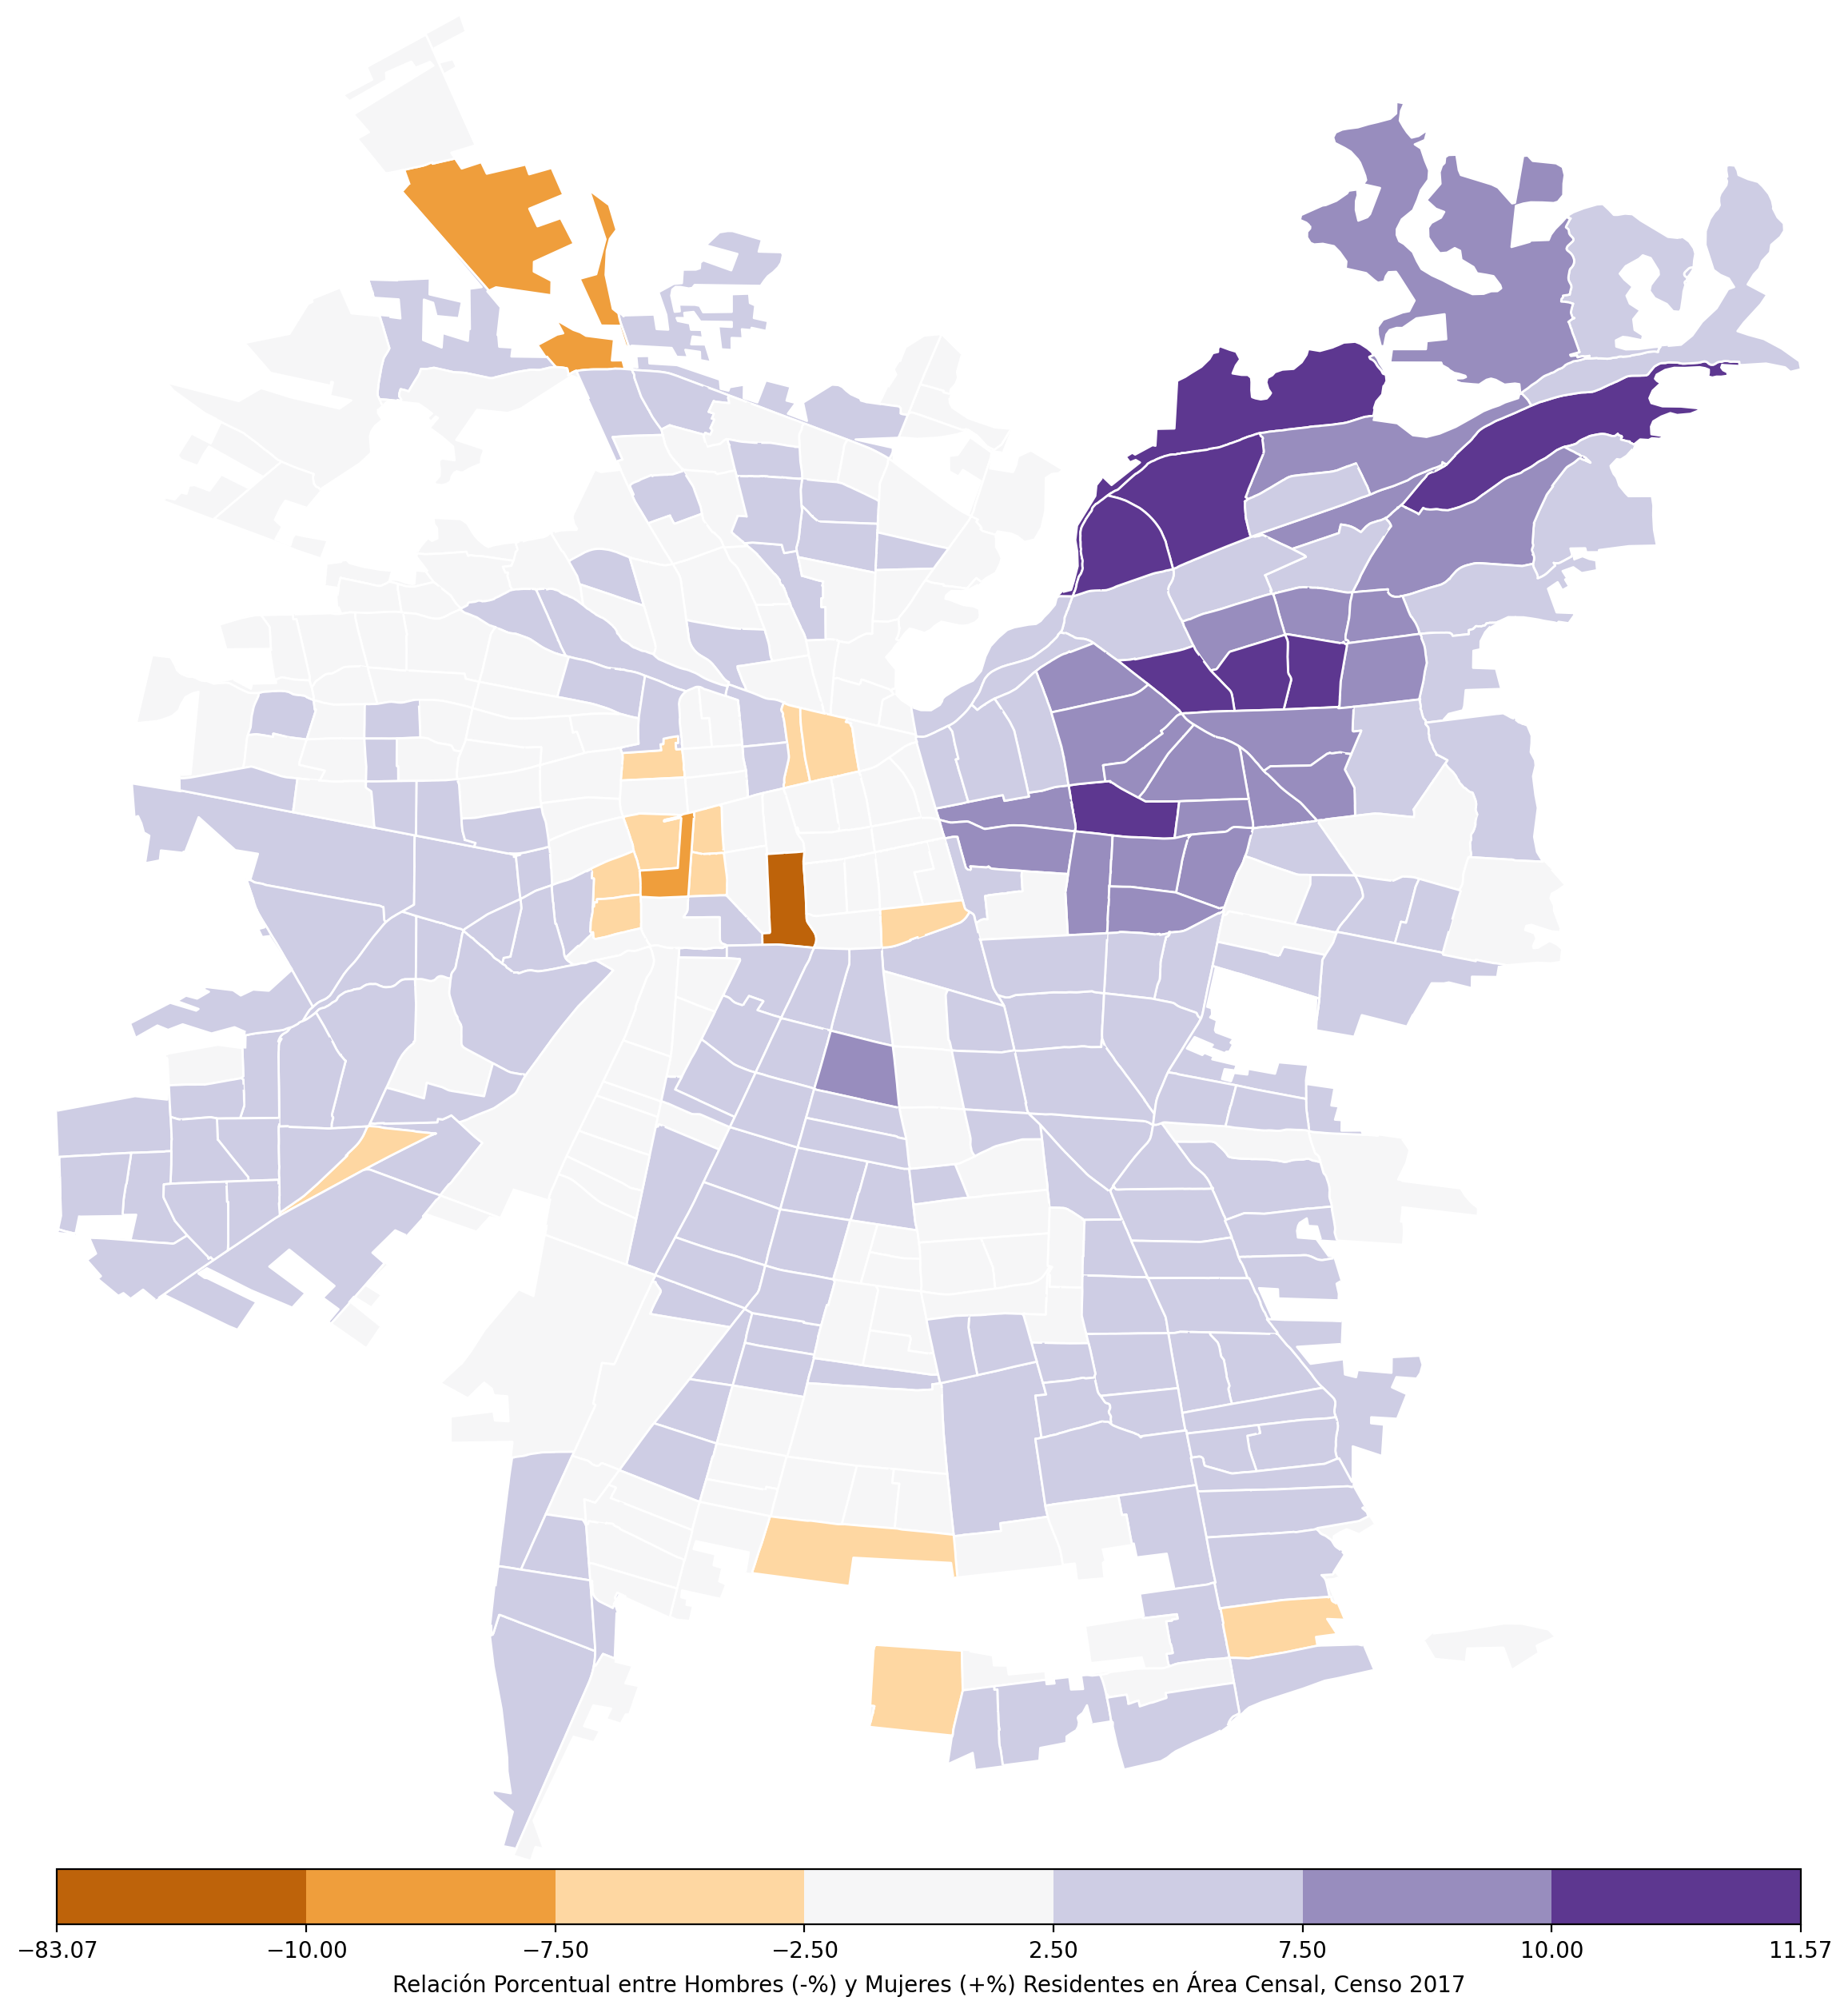

In [32]:
choropleth(urban_data, column='RATIO', alpha=1.0, cbar_orientation='horizontal', palette='PuOr', n_colors=7,
                     scheme='user_defined', user_bins=[urban_data.RATIO.min(), -10, -7.5, -2.5, 2.5, 7.5, 10, urban_data.RATIO.max()],
                     cbar_label='Relación Porcentual entre Hombres (-%) y Mujeres (+%) Residentes en Área Censal, Censo 2017')

<Axes: >

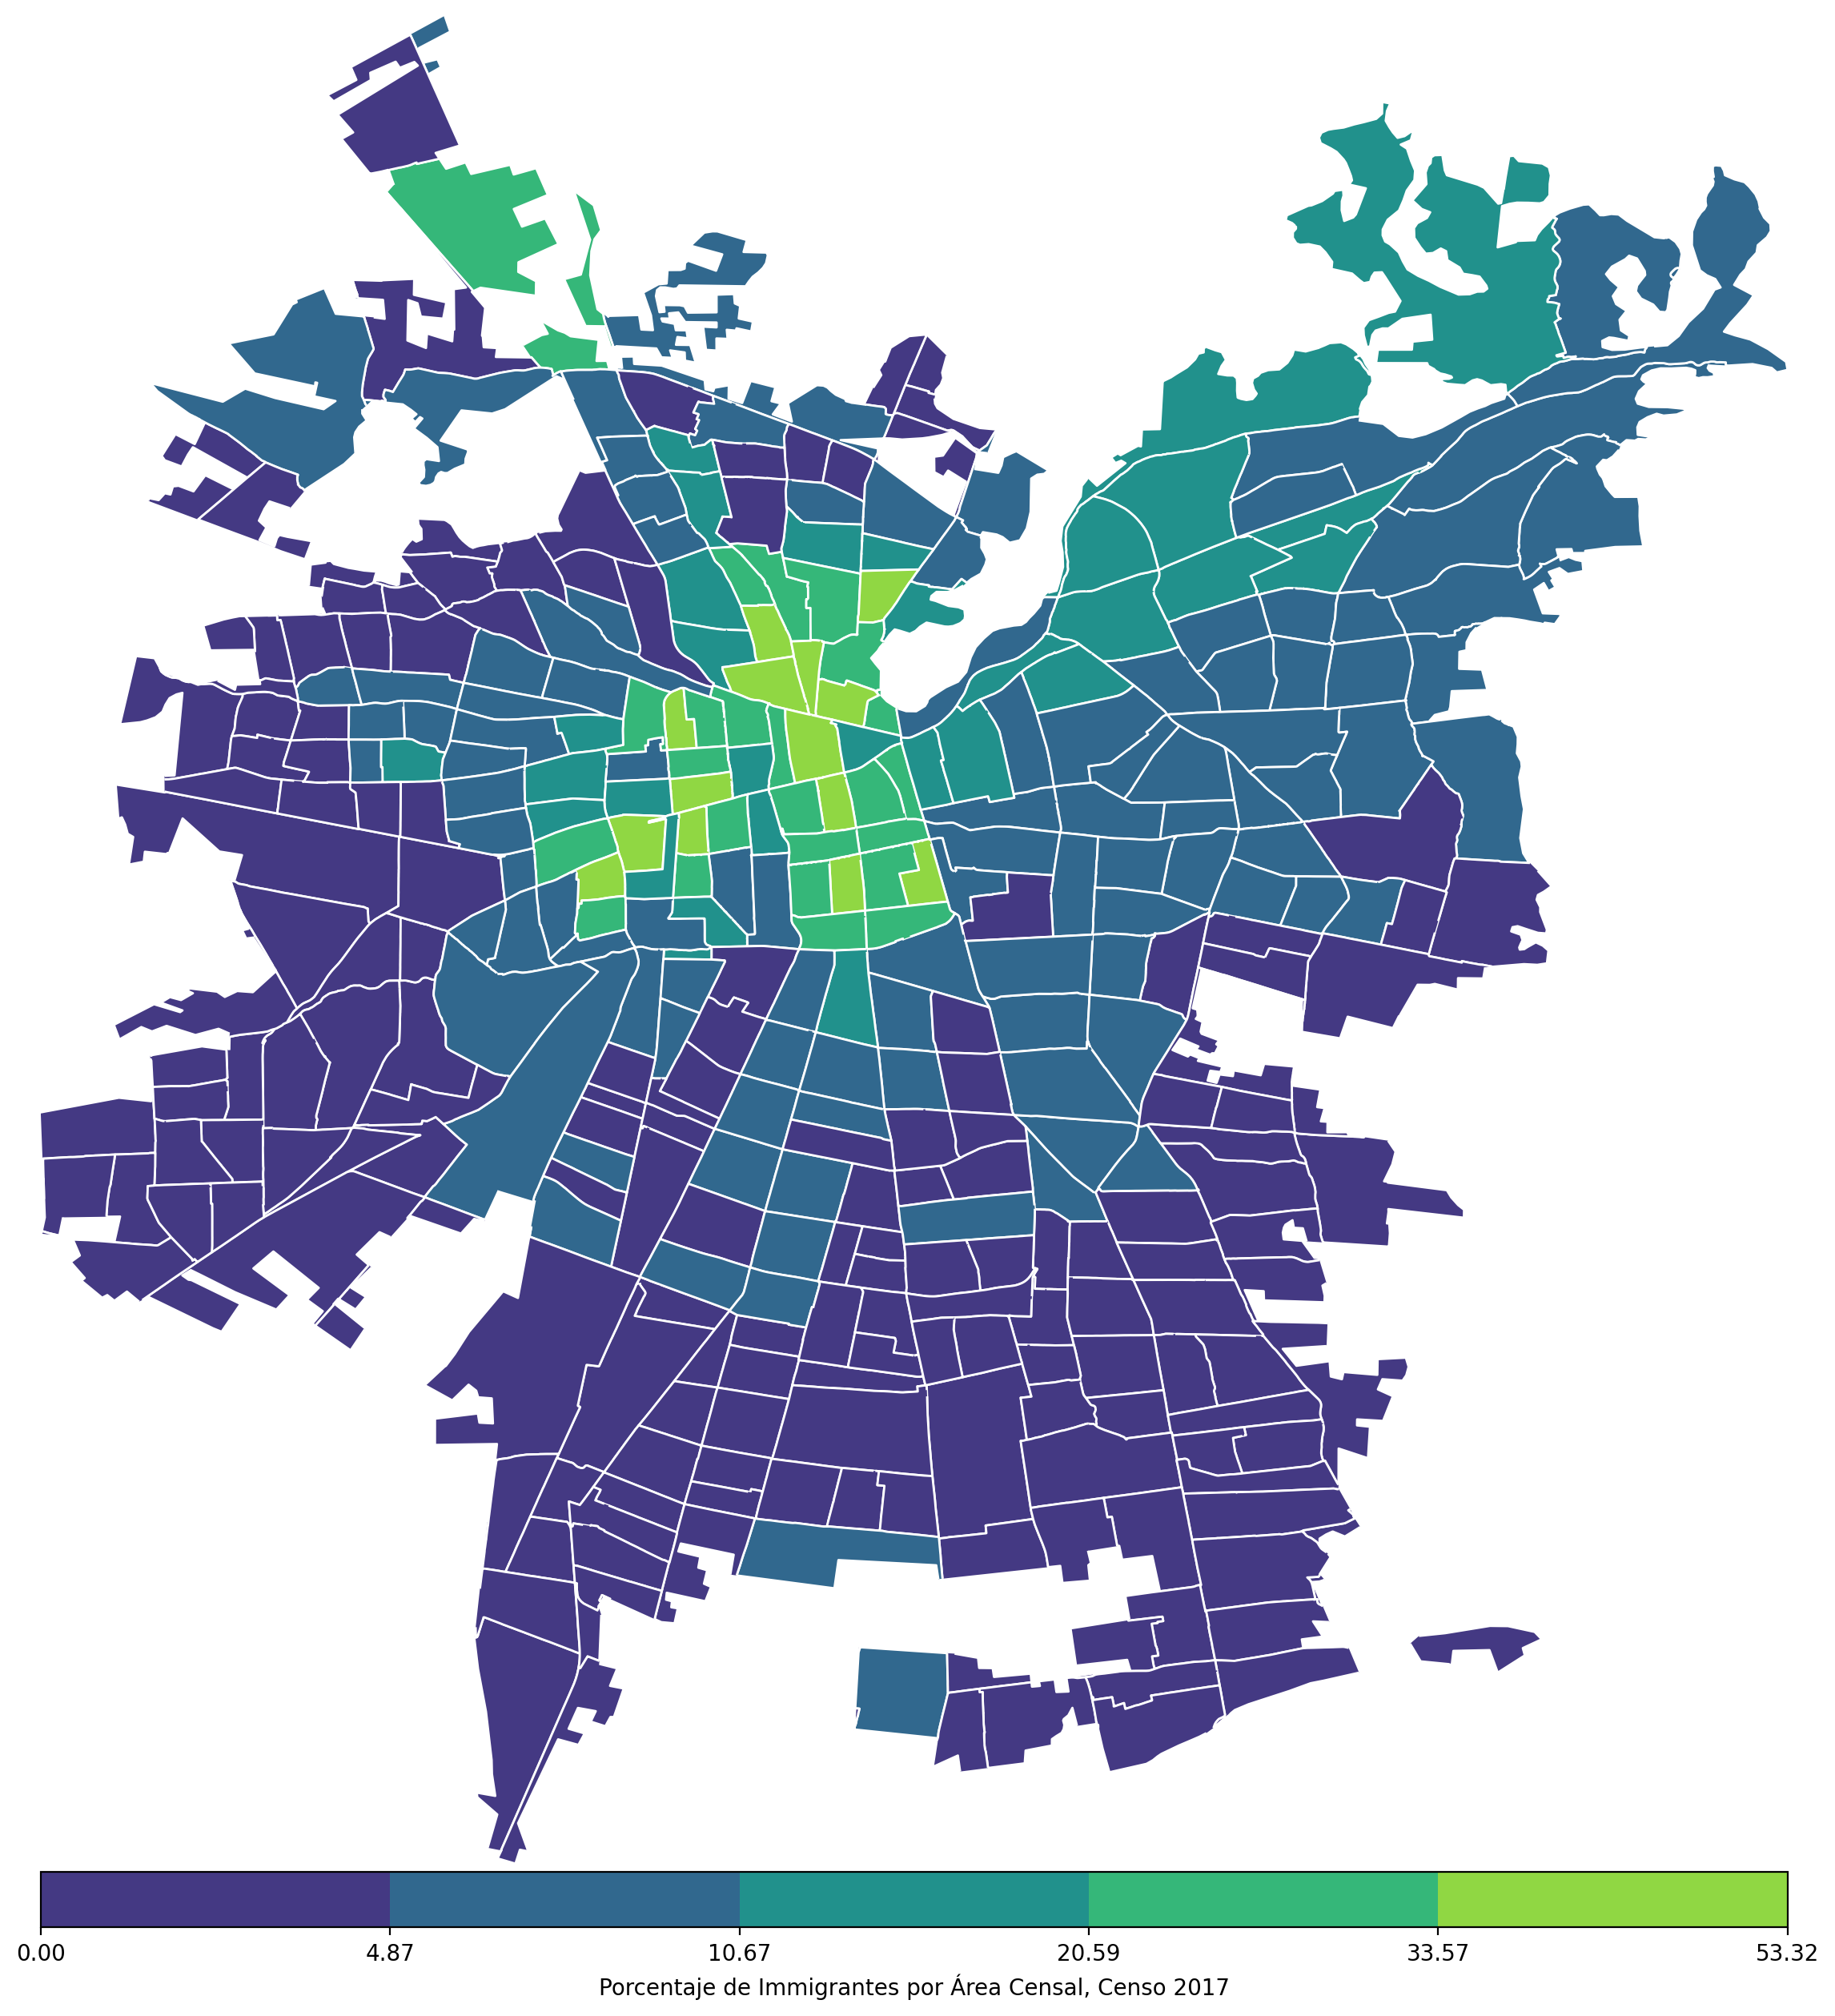

In [33]:
choropleth(urban_data, column='IMMIGRANT_%', alpha=1.0, cbar_orientation='horizontal', cbar_label='Porcentaje de Immigrantes por Área Censal, Censo 2017')